In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import ray
from ray.experimental.serve.examples.adder import ScalerAdder, VectorizedAdder
from ray.experimental.serve.examples.halt import SleepCounter, SleepOnFirst
from ray.experimental.serve.object_id import unwrap
from ray.experimental.serve.router import DeadlineAwareRouter, start_router
import time

In [3]:
import numpy as np

In [4]:
# We need at least 5 workers so resource won't be oversubscribed
ray.init()

# The following two blobs are equivalent
#
# handle = DeadlineAwareRouter.remote("DefaultTestRouter")
# ray.experimental.register_actor("DefaultTestRouter", handle)
# handle.start.remote()
#
# handle = start_router(DeadlineAwareRouter, "DefaultRouter")
handle = start_router(DeadlineAwareRouter, "DefaultRouter")


2019-05-07 23:07:10,921	WARNING worker.py:1344 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-05-07 23:07:10,924	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-07_23-07-10_22139/logs.
2019-05-07 23:07:11,044	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:29613 to respond...
2019-05-07 23:07:11,155	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:52732 to respond...
2019-05-07 23:07:11,157	INFO services.py:804 -- Starting Redis shard with 6.58 GB max memory.
2019-05-07 23:07:11,165	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-07_23-07-10_22139/logs.
2019-05-07 23:07:11,170	INFO services.py:1439 -- Starting the Plasma object store with 9.87 GB memory using /dev/shm.
2019-05-07 23:07:11,177	WARNING services.py:907 -- Failed to start

In [5]:
handle.register_actor.remote(
    "VAdder", VectorizedAdder,
    init_kwargs={"scaler_increment": 1},
    max_batch_size=1
)

ObjectID(01000000af83f5c7b6ec54ef7d4b6ebe61d830cb)

In [6]:
a = handle.call.remote("VAdder", 42, time.perf_counter() + 1)

In [7]:
ray.get(unwrap(a))

43

In [8]:
times = []
result = a
for _ in range(3):
    rt = []
    for i in range(0, 501, 10):
        for j in range(i):
            result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        ray.internal.free(result)
        rt += [after - now]
        print("# of tasks:", i, "; Latency:", after-now, "ns")
    times += [np.array(rt)]
times = np.array(times)
# times = np.load('latencies.npy')

# of tasks: 0 ; Latency: 0.000715428999683354 ns
# of tasks: 10 ; Latency: 0.017259262000152376 ns
# of tasks: 20 ; Latency: 0.03250552700046683 ns
# of tasks: 30 ; Latency: 0.05043257699981041 ns
# of tasks: 40 ; Latency: 0.06792547499935608 ns
# of tasks: 50 ; Latency: 0.08539085300071747 ns
# of tasks: 60 ; Latency: 0.08964176300105464 ns
# of tasks: 70 ; Latency: 0.10455929999989166 ns
# of tasks: 80 ; Latency: 0.11903903900019941 ns
# of tasks: 90 ; Latency: 0.15843294899968896 ns
# of tasks: 100 ; Latency: 0.15016771000045992 ns
# of tasks: 110 ; Latency: 0.17607855800088146 ns
# of tasks: 120 ; Latency: 0.1865545110013045 ns
# of tasks: 130 ; Latency: 0.20312037999974564 ns
# of tasks: 140 ; Latency: 0.2267511360005301 ns
# of tasks: 150 ; Latency: 0.22705004700037534 ns
# of tasks: 160 ; Latency: 0.23247930399884353 ns
# of tasks: 170 ; Latency: 0.26963411799988535 ns
# of tasks: 180 ; Latency: 0.30536477100031334 ns
# of tasks: 190 ; Latency: 0.2730379919994448 ns
# of tasks: 

In [9]:
np.save('latencies.npy', times)
times

array([[7.15429000e-04, 1.72592620e-02, 3.25055270e-02, 5.04325770e-02,
        6.79254750e-02, 8.53908530e-02, 8.96417630e-02, 1.04559300e-01,
        1.19039039e-01, 1.58432949e-01, 1.50167710e-01, 1.76078558e-01,
        1.86554511e-01, 2.03120380e-01, 2.26751136e-01, 2.27050047e-01,
        2.32479304e-01, 2.69634118e-01, 3.05364771e-01, 2.73037992e-01,
        3.00398397e-01, 3.42841059e-01, 3.23160880e-01, 3.58812117e-01,
        4.17958499e-01, 4.10708662e-01, 4.42167911e-01, 4.31643946e-01,
        4.56161289e-01, 4.60879060e-01, 4.86896666e-01, 4.61326493e-01,
        4.97306538e-01, 5.19980917e-01, 5.48627121e-01, 5.40847012e-01,
        5.94496936e-01, 5.81331932e-01, 6.10441017e-01, 6.38044216e-01,
        6.15810184e-01, 6.34124525e-01, 6.39494049e-01, 6.70519343e-01,
        6.86593478e-01, 6.95138262e-01, 6.79959971e-01, 7.00522965e-01,
        7.52709937e-01, 7.62902833e-01, 8.01142499e-01],
       [7.64347000e-04, 1.59266820e-02, 3.16855820e-02, 4.91844360e-02,
       

In [11]:
import matplotlib.pyplot as plt

In [32]:
times = np.load('latencies.npy')
avg = np.sum(times, axis=0)/np.float(3)
xs = np.array([1] + list(np.arange(10, 501, 10)))

In [33]:
avg

array([6.54157334e-04, 1.66195453e-02, 3.25015040e-02, 4.77397777e-02,
       6.73338457e-02, 7.98320537e-02, 8.99796210e-02, 1.01820422e-01,
       1.21970146e-01, 1.46169622e-01, 1.58618648e-01, 1.72175061e-01,
       1.88305062e-01, 2.11487568e-01, 2.36964296e-01, 2.52712574e-01,
       2.63815634e-01, 2.68082441e-01, 2.93511495e-01, 2.97533035e-01,
       3.18407587e-01, 3.55468958e-01, 3.31223028e-01, 3.55475281e-01,
       4.03521139e-01, 4.02728652e-01, 4.09564206e-01, 4.11539018e-01,
       4.44031243e-01, 4.44441405e-01, 4.72416099e-01, 4.72509629e-01,
       4.78973303e-01, 5.02987037e-01, 5.28929481e-01, 5.38081516e-01,
       5.54654233e-01, 5.77643802e-01, 6.29312824e-01, 6.09740539e-01,
       6.40052723e-01, 6.55642557e-01, 6.47414456e-01, 6.54341986e-01,
       7.10017542e-01, 6.88920778e-01, 7.17847915e-01, 7.14979062e-01,
       7.65127098e-01, 8.01393869e-01, 8.04746562e-01])

In [37]:
np.max(xs[1:]/avg[1:])

687.4848741054819

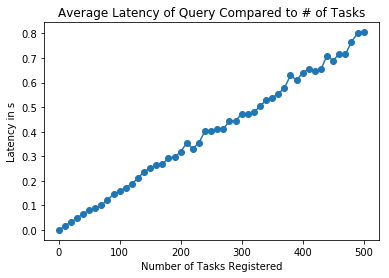

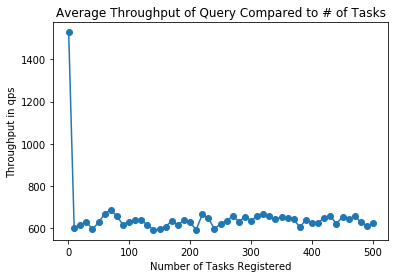

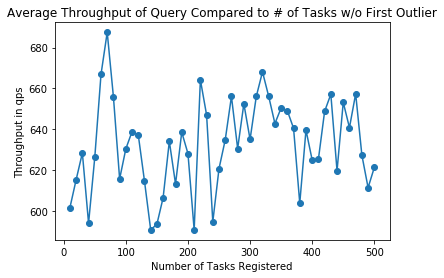

In [22]:
plt.plot(xs, avg, 'o-')
plt.title("Average Latency of Query Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Latency in s");
plt.figure()
plt.plot(xs, xs/avg, 'o-')
plt.title("Average Throughput of Query Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Throughput in qps");
plt.figure()
plt.plot(xs[1:], xs[1:]/avg[1:], 'o-')
plt.title("Average Throughput of Query Compared to # of Tasks w/o First Outlier")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Throughput in qps");

In [14]:
times = []
result = a
for _ in range(3):
    rt = []
    for i in range(1, 501, 1):
        result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        ray.internal.free(result)
        rt += [after - now]
        print("Query ID:", i, "; Latency:", after-now, "ns")
    times += [np.array(rt)]

Query ID: 1 ; Latency: 0.003117229000054067 ns
Query ID: 2 ; Latency: 0.002601651000077254 ns
Query ID: 3 ; Latency: 0.0021498420010175323 ns
Query ID: 4 ; Latency: 0.002630210999996052 ns
Query ID: 5 ; Latency: 0.0024329110001417575 ns
Query ID: 6 ; Latency: 0.002129499998773099 ns
Query ID: 7 ; Latency: 0.002495038001143257 ns
Query ID: 8 ; Latency: 0.0022886890001245774 ns
Query ID: 9 ; Latency: 0.002491068000381347 ns
Query ID: 10 ; Latency: 0.0021303140001691645 ns
Query ID: 11 ; Latency: 0.002798249000989017 ns
Query ID: 12 ; Latency: 0.0026239130002068123 ns
Query ID: 13 ; Latency: 0.002760975999990478 ns
Query ID: 14 ; Latency: 0.00230319500042242 ns
Query ID: 15 ; Latency: 0.0027401480001572054 ns
Query ID: 16 ; Latency: 0.0026611939993017586 ns
Query ID: 17 ; Latency: 0.002194750999478856 ns
Query ID: 18 ; Latency: 0.0027028510012314655 ns
Query ID: 19 ; Latency: 0.002165285000955919 ns
Query ID: 20 ; Latency: 0.002772054000161006 ns
Query ID: 21 ; Latency: 0.0025112960011028

Query ID: 219 ; Latency: 0.002709836999201798 ns
Query ID: 220 ; Latency: 0.002231609998489148 ns
Query ID: 221 ; Latency: 0.0027506279984663706 ns
Query ID: 222 ; Latency: 0.0027130239996040473 ns
Query ID: 223 ; Latency: 0.0022208040008990793 ns
Query ID: 224 ; Latency: 0.0023229219987115357 ns
Query ID: 225 ; Latency: 0.002372488999753841 ns
Query ID: 226 ; Latency: 0.002734083000177634 ns
Query ID: 227 ; Latency: 0.0028470710003603017 ns
Query ID: 228 ; Latency: 0.0023132160004024627 ns
Query ID: 229 ; Latency: 0.002748529999735183 ns
Query ID: 230 ; Latency: 0.002365974998610909 ns
Query ID: 231 ; Latency: 0.0025767450006242143 ns
Query ID: 232 ; Latency: 0.002244420998977148 ns
Query ID: 233 ; Latency: 0.002695234999919194 ns
Query ID: 234 ; Latency: 0.002250498000648804 ns
Query ID: 235 ; Latency: 0.002094835001116735 ns
Query ID: 236 ; Latency: 0.00263582099978521 ns
Query ID: 237 ; Latency: 0.0027153089995408664 ns
Query ID: 238 ; Latency: 0.002672123000593274 ns
Query ID: 239

Query ID: 436 ; Latency: 0.002835930999935954 ns
Query ID: 437 ; Latency: 0.0026566119995550252 ns
Query ID: 438 ; Latency: 0.002680540999790537 ns
Query ID: 439 ; Latency: 0.002228035998996347 ns
Query ID: 440 ; Latency: 0.0023093199997674674 ns
Query ID: 441 ; Latency: 0.002402670001174556 ns
Query ID: 442 ; Latency: 0.002242648999526864 ns
Query ID: 443 ; Latency: 0.0022808049998275237 ns
Query ID: 444 ; Latency: 0.002305545998751768 ns
Query ID: 445 ; Latency: 0.0023538099994766526 ns
Query ID: 446 ; Latency: 0.0023179300005722325 ns
Query ID: 447 ; Latency: 0.0023260550005943514 ns
Query ID: 448 ; Latency: 0.0021752299999207025 ns
Query ID: 449 ; Latency: 0.002394198998445063 ns
Query ID: 450 ; Latency: 0.0022726370007148944 ns
Query ID: 451 ; Latency: 0.002338410000447766 ns
Query ID: 452 ; Latency: 0.0023087919998943107 ns
Query ID: 453 ; Latency: 0.002413444000922027 ns
Query ID: 454 ; Latency: 0.002284140000483603 ns
Query ID: 455 ; Latency: 0.0023520659997302573 ns
Query ID: 

Query ID: 156 ; Latency: 0.002739630999712972 ns
Query ID: 157 ; Latency: 0.0023928080008772667 ns
Query ID: 158 ; Latency: 0.0022868089999974472 ns
Query ID: 159 ; Latency: 0.0027433499999460764 ns
Query ID: 160 ; Latency: 0.002757935999397887 ns
Query ID: 161 ; Latency: 0.0024147200001607416 ns
Query ID: 162 ; Latency: 0.0022176299989951076 ns
Query ID: 163 ; Latency: 0.002173670000047423 ns
Query ID: 164 ; Latency: 0.0020644679989345605 ns
Query ID: 165 ; Latency: 0.0022148749994812533 ns
Query ID: 166 ; Latency: 0.002182879999963916 ns
Query ID: 167 ; Latency: 0.0021586780003417516 ns
Query ID: 168 ; Latency: 0.0027193280002393294 ns
Query ID: 169 ; Latency: 0.002131560000634636 ns
Query ID: 170 ; Latency: 0.0021897999995417194 ns
Query ID: 171 ; Latency: 0.002095883999572834 ns
Query ID: 172 ; Latency: 0.002064614000119036 ns
Query ID: 173 ; Latency: 0.0021576740000455175 ns
Query ID: 174 ; Latency: 0.0021271320001687855 ns
Query ID: 175 ; Latency: 0.0020408159998623887 ns
Query I

Query ID: 375 ; Latency: 0.0023378050009341678 ns
Query ID: 376 ; Latency: 0.00224221300049976 ns
Query ID: 377 ; Latency: 0.0023513619998993818 ns
Query ID: 378 ; Latency: 0.0025030090000655036 ns
Query ID: 379 ; Latency: 0.002559290000135661 ns
Query ID: 380 ; Latency: 0.002555846000177553 ns
Query ID: 381 ; Latency: 0.002542084999731742 ns
Query ID: 382 ; Latency: 0.0025452169993513962 ns
Query ID: 383 ; Latency: 0.002256888999909279 ns
Query ID: 384 ; Latency: 0.0025411120004719123 ns
Query ID: 385 ; Latency: 0.002219097999841324 ns
Query ID: 386 ; Latency: 0.002685416999156587 ns
Query ID: 387 ; Latency: 0.0024498200000380166 ns
Query ID: 388 ; Latency: 0.002729312998781097 ns
Query ID: 389 ; Latency: 0.0024802810003166087 ns
Query ID: 390 ; Latency: 0.002510390000679763 ns
Query ID: 391 ; Latency: 0.0020830169996770564 ns
Query ID: 392 ; Latency: 0.0022647340010735206 ns
Query ID: 393 ; Latency: 0.0022620569998252904 ns
Query ID: 394 ; Latency: 0.002277527000842383 ns
Query ID: 3

Query ID: 105 ; Latency: 0.0022758600007364294 ns
Query ID: 106 ; Latency: 0.002148284000213607 ns
Query ID: 107 ; Latency: 0.0024028530006035 ns
Query ID: 108 ; Latency: 0.0021471420004672837 ns
Query ID: 109 ; Latency: 0.0023239900001499336 ns
Query ID: 110 ; Latency: 0.0022472299988294253 ns
Query ID: 111 ; Latency: 0.002323837999938405 ns
Query ID: 112 ; Latency: 0.002541099000154645 ns
Query ID: 113 ; Latency: 0.0022575620005227393 ns
Query ID: 114 ; Latency: 0.002567146000728826 ns
Query ID: 115 ; Latency: 0.0021971690002828836 ns
Query ID: 116 ; Latency: 0.0024884389986254973 ns
Query ID: 117 ; Latency: 0.002307497001311276 ns
Query ID: 118 ; Latency: 0.0021841910001967335 ns
Query ID: 119 ; Latency: 0.002134644999387092 ns
Query ID: 120 ; Latency: 0.0021831649992236635 ns
Query ID: 121 ; Latency: 0.0021093299983476754 ns
Query ID: 122 ; Latency: 0.0021524059993680567 ns
Query ID: 123 ; Latency: 0.002417449000859051 ns
Query ID: 124 ; Latency: 0.002527895001549041 ns
Query ID: 1

Query ID: 327 ; Latency: 0.002832169000612339 ns
Query ID: 328 ; Latency: 0.0027307609998388216 ns
Query ID: 329 ; Latency: 0.002222524000899284 ns
Query ID: 330 ; Latency: 0.002704718999666511 ns
Query ID: 331 ; Latency: 0.002635382999869762 ns
Query ID: 332 ; Latency: 0.0027135640011692885 ns
Query ID: 333 ; Latency: 0.002694132999749854 ns
Query ID: 334 ; Latency: 0.0027123569998366293 ns
Query ID: 335 ; Latency: 0.0027341120003256947 ns
Query ID: 336 ; Latency: 0.0026202920016658027 ns
Query ID: 337 ; Latency: 0.002751698999418295 ns
Query ID: 338 ; Latency: 0.00223812399963208 ns
Query ID: 339 ; Latency: 0.002718364999964251 ns
Query ID: 340 ; Latency: 0.0022236189997784095 ns
Query ID: 341 ; Latency: 0.002698772999792709 ns
Query ID: 342 ; Latency: 0.0026661239990062313 ns
Query ID: 343 ; Latency: 0.0024905299997044494 ns
Query ID: 344 ; Latency: 0.0024795749995973893 ns
Query ID: 345 ; Latency: 0.0024733430000196677 ns
Query ID: 346 ; Latency: 0.0024562379985582083 ns
Query ID: 

In [15]:
avg = np.sum(times, axis=0)/np.float(3)
xs = np.array(list(np.arange(1, 501, 1)))
xs

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [16]:
np.save('latencies_single_query.npy', times)

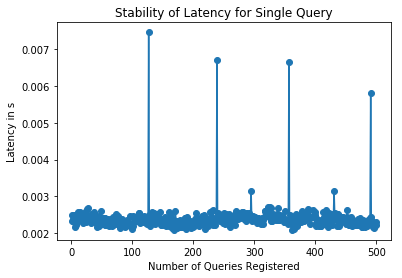

In [24]:
times = np.load('latencies_single_query.npy')
avg = np.sum(times, axis=0)/np.float(3)
xs = np.array(list(np.arange(1, 501, 1)))
plt.plot(xs, avg, 'o-')
plt.title("Stability of Latency for Single Query")
plt.xlabel("Number of Queries Registered")
plt.ylabel("Latency in s");
plt.show()

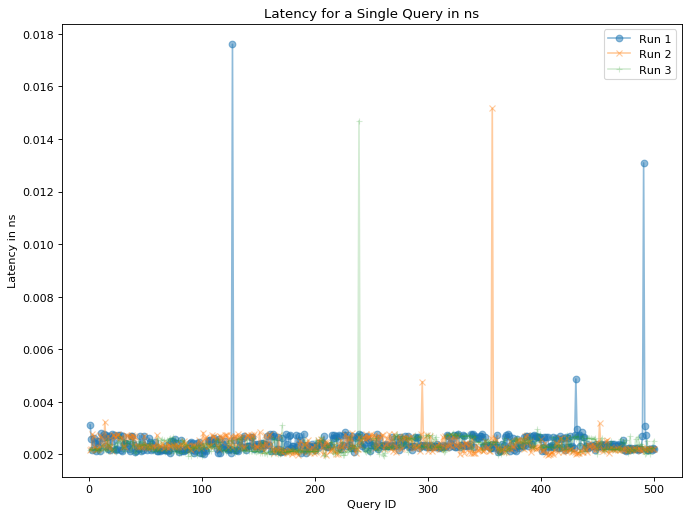

In [26]:
times = np.load('latencies_single_query.npy')
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 7.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(1, 501, 1), times[0], 'o-', label='Run 1', alpha=0.5)
plt.plot(np.arange(1, 501, 1), times[1], 'x-', label='Run 2', alpha=0.4)
plt.plot(np.arange(1, 501, 1), times[2], '+-', label='Run 3', alpha=0.2)
plt.legend()
plt.title("Latency for a Single Query in ns")
plt.xlabel("Query ID")
plt.ylabel("Latency in ns");

In [ ]:
np.save('latencysq.npy', times)

In [27]:
reps = []
for i in range(1,4):
    handle.set_replica.remote("VAdder", i)
    total = 0.0
    for _ in range(3):
        for i in range(0, 1001, 10):
            result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
        now = time.perf_counter()
        ray.get(unwrap(result))
        after = time.perf_counter()
        ray.internal.free(result)
        total += (after - now)
    total /= 3.0
    reps += [total]
reps = np.array(reps)
reps

array([0.15812935, 0.17178224, 0.14919937])

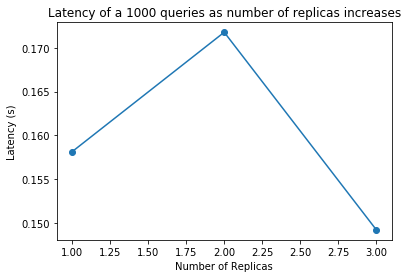

In [31]:
nxs = np.arange(1,4)
plt.plot(nxs, reps, "o-")
plt.title("Latency of a 1000 queries as number of replicas increases")
plt.xlabel("Number of Replicas")
plt.ylabel("Latency (s)");